<a href="https://colab.research.google.com/github/jamslaugh/My-Datascience-Projects/blob/master/Kaggle_Cactus_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
try:
    %tensorflow_version 2.x 
except:
    pass
import PIL
import pandas as pd
import os
import numpy as np
import xgboost
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, MaxPool2D, AveragePooling2D, Flatten,Reshape, Dropout,BatchNormalization,Activation
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping, History, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
import json

token = {"username":"randomcluster","key":"c11f4b3b630cb22dab26811652171286"}

with open('kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3086            True  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11536            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4593            True  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         45           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3553           False  
open-images-2019-object-detection                  2019-10-01 23:59:00  Research           $25,000      

In [ ]:
!mkdir ./Cactus

In [ ]:
!ls

Cactus	kaggle.json  sample_data


In [ ]:
os.chdir(os.getcwd()+"/Cactus")

In [ ]:
!kaggle competitions download aerial-cactus-identification

  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 42.3MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 49.4MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 66.0MB/s]
 73% 14.0M/19.2M [00:00<00:00, 38.7MB/s]
100% 19.2M/19.2M [00:00<00:00, 63.7MB/s]


In [ ]:
!ls

sample_submission.csv  test.zip  train.csv  train.zip


In [ ]:
!unzip train.zip & unzip test.zip

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
!ls ./test

In [ ]:
np.reshape(np.array(PIL.Image.open("./train/"+data.iloc[0,0])),(-1,1)).T.shape

(1, 3072)

In [ ]:
data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [ ]:
new_data={el:np.reshape(np.array(PIL.Image.open("./train/"+el)),(-1,)).T for el in data.id}

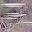

In [ ]:
PIL.Image.open("./train/0004be2cfeaba1c0361d39e2b000257b.jpg")

In [ ]:
df = pd.DataFrame.from_dict(new_data,orient='index').reset_index().rename({'index':'id'},axis=1)

In [ ]:
df.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0004be2cfeaba1c0361d39e2b000257b.jpg,136,138,125,134,136,125,147,148,140,136,135,130,116,112,111,100,96,97,100,93,100,116,106,115,102,92,103,125,113,127,120,108,122,120,106,121,126,112,125,...,147,171,151,150,169,149,150,162,142,143,158,136,139,161,138,144,176,153,161,162,136,147,156,130,143,167,140,155,172,143,161,179,150,168,142,113,133,139,110,130
1,000c8a36845c0208e833c79c1bffedd1.jpg,118,109,114,108,99,104,104,95,100,110,100,108,85,74,82,55,43,53,86,74,84,82,69,79,109,93,104,134,116,128,126,108,120,124,104,116,128,106,118,...,102,128,117,123,148,139,144,147,138,143,105,96,101,94,84,92,121,111,119,141,130,138,124,112,122,154,142,152,143,130,140,104,91,101,97,81,92,126,110,121
2,000d1e9a533f62e55c289303b072733d.jpg,158,139,158,158,139,158,159,141,157,168,150,166,145,127,141,121,105,118,142,126,137,134,118,129,155,139,150,137,119,131,168,150,162,168,150,162,96,75,90,...,125,158,136,139,115,92,98,162,139,145,149,126,132,154,129,135,145,120,126,171,146,152,130,104,113,156,130,139,158,132,141,163,137,146,161,135,144,152,126,135
3,0011485b40695e9138e92d0b3fb55128.jpg,147,133,146,122,108,121,101,87,100,126,112,127,126,112,127,131,117,132,133,116,132,112,95,113,157,138,157,165,143,164,160,136,158,136,111,133,135,105,129,...,116,182,166,179,141,125,136,143,125,137,139,121,135,145,127,141,67,46,63,134,113,132,181,157,179,148,124,146,108,85,105,139,114,135,133,108,127,138,113,132
4,0014d7a11e90b62848904c1418fc8cf2.jpg,113,99,98,109,95,95,123,108,111,156,141,146,154,139,144,128,111,119,119,102,110,119,102,108,101,84,90,79,64,67,129,114,117,147,132,137,125,112,119,...,141,172,177,155,159,164,141,147,152,129,125,131,105,81,87,61,94,103,74,155,164,135,133,142,113,151,160,133,134,143,116,74,83,56,50,59,32,128,137,110


In [ ]:
new_data = df.merge(data, on='id')

In [ ]:
new_data.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,136,138,125,134,136,125,147,148,140,136,135,130,116,112,111,100,96,97,100,93,100,116,106,115,102,92,103,125,113,127,120,108,122,120,106,121,126,112,125,...,171,151,150,169,149,150,162,142,143,158,136,139,161,138,144,176,153,161,162,136,147,156,130,143,167,140,155,172,143,161,179,150,168,142,113,133,139,110,130,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,118,109,114,108,99,104,104,95,100,110,100,108,85,74,82,55,43,53,86,74,84,82,69,79,109,93,104,134,116,128,126,108,120,124,104,116,128,106,118,...,128,117,123,148,139,144,147,138,143,105,96,101,94,84,92,121,111,119,141,130,138,124,112,122,154,142,152,143,130,140,104,91,101,97,81,92,126,110,121,1
2,000d1e9a533f62e55c289303b072733d.jpg,158,139,158,158,139,158,159,141,157,168,150,166,145,127,141,121,105,118,142,126,137,134,118,129,155,139,150,137,119,131,168,150,162,168,150,162,96,75,90,...,158,136,139,115,92,98,162,139,145,149,126,132,154,129,135,145,120,126,171,146,152,130,104,113,156,130,139,158,132,141,163,137,146,161,135,144,152,126,135,1
3,0011485b40695e9138e92d0b3fb55128.jpg,147,133,146,122,108,121,101,87,100,126,112,127,126,112,127,131,117,132,133,116,132,112,95,113,157,138,157,165,143,164,160,136,158,136,111,133,135,105,129,...,182,166,179,141,125,136,143,125,137,139,121,135,145,127,141,67,46,63,134,113,132,181,157,179,148,124,146,108,85,105,139,114,135,133,108,127,138,113,132,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,113,99,98,109,95,95,123,108,111,156,141,146,154,139,144,128,111,119,119,102,110,119,102,108,101,84,90,79,64,67,129,114,117,147,132,137,125,112,119,...,172,177,155,159,164,141,147,152,129,125,131,105,81,87,61,94,103,74,155,164,135,133,142,113,151,160,133,134,143,116,74,83,56,50,59,32,128,137,110,1


In [ ]:
y = new_data.has_cactus

In [ ]:
new_data.drop('has_cactus',axis=1,inplace=True)

In [ ]:
new_data.drop('id',axis=1,inplace=True)

In [ ]:
model = Sequential()
model.add(Reshape((32,32,3),input_shape=(new_data.shape[1],)))
model.add(Conv2D(32,kernel_size=(5,5),padding='same',strides=[1,1],kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Conv2D(64,kernel_size=(5,5),padding='valid',strides=[1,1],kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(1000, activation = 'relu',kernel_initializer='glorot_normal'))
model.add(Dropout(rate=0.4))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer=Adam(lr=0.0005,beta_1=0.99,beta_2=0.999),loss='binary_crossentropy',metrics=['accuracy'])
model.fit(new_data,y,validation_split=0.1,epochs=30,batch_size=128)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15750 samples, validate on 1750 samples
Epoch 1/30
15750/15750 [==============================] - 8s 498us/step - loss: 0.3819 - acc: 0.9018 - val_loss: 0.4437 - val_acc: 0.8097
Epoch 2/30
15750/15750 [==============================] - 4s 233us/step - loss: 0.1296 - acc: 0.9512 - val_loss: 0.2891 - val_acc: 0.8800
Epoch 3/30
15750/15750 [==============================] - 4s 230us/step - loss: 0.0869 - acc: 0.9674 - val_loss: 0.2700 - val_acc: 0.8766
Epoch 4/30
15750/15750 [==============================] - 4s 233us/step - loss: 0.0664 - acc: 0.9744 - val_loss: 0.0569 - val_acc: 0.9783
Epoch 5/30
15750/15750 [==============================] - 4s 235us/step - loss: 0.0552 - acc: 0.9789 - val_loss: 0.1034 - val_acc: 0.9560
Epoch 6/30
15750/15750 [==============================] - 4s 231us/step - loss: 0.0481 - acc: 0.9809 - val_loss: 0.0603 - val_acc: 0.9754
Epoch 7/30
15750/15750 [=

In [ ]:
pd.read_csv('sample_submission.csv').head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [ ]:
test_data = {el:np.reshape(np.array(PIL.Image.open("./test/"+el)),(-1,)).T for el in os.listdir("./test")}

In [ ]:
X_test = pd.DataFrame.from_dict(test_data,orient='index')

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred

array([[9.9999988e-01],
       [3.0014217e-03],
       [1.0000000e+00],
       ...,
       [5.9604645e-07],
       [4.0681064e-03],
       [1.0000000e+00]], dtype=float32)

In [ ]:
submission = {'id':X_test.index.to_list(),'has_cactus':pred}

In [ ]:
has_cactus = pd.DataFrame(submission['has_cactus'])
iD = pd.DataFrame(submission['id'])

In [ ]:
submit = pd.concat([iD,has_cactus],axis=1)

In [ ]:
submit.columns = ['id','has_cactus']

In [ ]:
submit.head()

,id,has_cactus
0,4b7b8ec5227506e335e399e8450c0011.jpg,1.000000
1,25283c5f4d77d763ad3817dbc90248c9.jpg,0.003001
2,b047c34e79dbfb22deadba14bbfcb24c.jpg,1.000000
3,2a127d250a0ff4de88222b2ed7c5eaca.jpg,0.108140
4,586bf8d63e9be36ba044a96cad1d0453.jpg,1.000000


In [ ]:
submit.to_csv('submission.csv',index=False)

In [ ]:
!kaggle competitions submit -c aerial-cactus-identification -f submission.csv -m "Message"

100% 177k/177k [00:06<00:00, 28.5kB/s]
403 - This competition only allows kernel submissions.


In [ ]:
pd.read_csv('submission.csv').head()

,id,has_cactus
0,4b7b8ec5227506e335e399e8450c0011.jpg,1.000000
1,25283c5f4d77d763ad3817dbc90248c9.jpg,0.003001
2,b047c34e79dbfb22deadba14bbfcb24c.jpg,1.000000
3,2a127d250a0ff4de88222b2ed7c5eaca.jpg,0.108140
4,586bf8d63e9be36ba044a96cad1d0453.jpg,1.000000
